### 1. Importing Libraries

In [1]:
import os
import glob
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import utils

### Loading Data
Use the `ImageFolder` class to load the data.
The `ImageFolder` class will automatically label the images based on the folder they are in. The folder names are the labels.
The `ImageFolder` class will also automatically resize the images to the size specified in the `transform` argument.
The `ImageFolder` class will also automatically convert the images to PyTorch tensors.

In [3]:
os.getcwd()

'/home/diaa/My_PRinAI'

In [6]:
data_dir = './lfw'

dataset = ImageFolder(data_dir, transforms.Compose([
                                                    transforms.Resize((64, 64)), # Resize the image to 250x250
                                                    transforms.ToTensor() ]))      # Converts the image to a tensor

print(f'There are {len(os.listdir(data_dir))} classes.')
print(f'There are {len(dataset)} images.')

There are 5749 classes.
There are 13233 images.


**Get the class names.**

In [7]:
class_names = dataset.classes
class_labels = {i: class_names[i] for i in range(len(class_names))}

class_dict = {v: k for k, v in class_labels.items()}

In [8]:
# import pandas as pd

# label_counts = pd.Series(dataset.targets).value_counts().sort_index()

# dist_class = {label: count for label, count in zip(dataset.classes, label_counts)}

# dist_class

**Visualize one image.**

Text(0.5, 1.0, 'AJ_Cook')

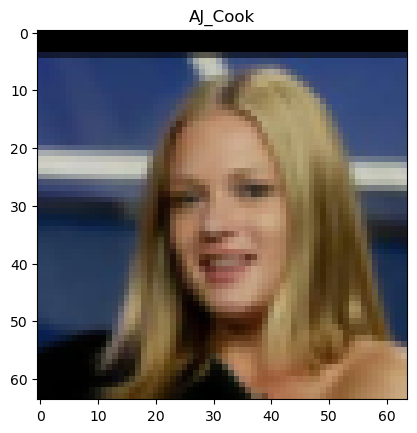

In [9]:
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0))
plt.title(class_labels[label])

**Split the data into training and validation sets.**

In [10]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size  # 0.02 * len(dataset)

print(f'Training size: {train_size}')
print(f'Validation size: {val_size}')
print(f'test size: {test_size}')

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

Training size: 10586
Validation size: 1984
test size: 663


**Create data loaders.**

In [7]:
from torch.utils.data import DataLoader


batch_size = 96

train_loader = DataLoader(train_ds,
                           batch_size,
                           shuffle=True,
                           num_workers=4,
                           pin_memory=True)

val_loader = DataLoader(val_ds,
                        batch_size,
                        num_workers=4,
                        pin_memory=True)

test_loader = DataLoader(test_ds,
                         batch_size,
                         num_workers=4,
                         pin_memory=True)

In [8]:
device = utils.get_default_device()  # Defaults to GPU if available, else CPU

# Wrap dataloader to move data to the device selected above
train_loader = utils.DeviceDataLoader(train_loader, device)
val_loader =  utils.DeviceDataLoader(val_loader, device)
test_loader = utils.DeviceDataLoader(test_loader, device)

### 2. Defining the Model
We will use a handwritten ResNet-9 model.

In [10]:
from models.resnet9 import ResNet9


# Input channels = 3 (RGB), output channels = (number of classes)
model = ResNet9(3, len(class_names))

model = utils.to_device(model, device)

# Pass one batch of data through the model to see the output shape
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out.device:', out.device)
    break

images.shape: torch.Size([96, 3, 64, 64])
out.shape: torch.Size([96, 5749])
out.device: cuda:0


In [ ]:
# Establishing a baseline accuracy
baseline_acc = utils.evaluate(model, val_loader)

print(f'Baseline accuracy: {baseline_acc["val_acc"]*100:.3f}%')

Baseline accuracy: 0.050%


In [ ]:
start_time = time.perf_counter()
history = [baseline_acc] + utils.fit(epochs=2, lr=1e-3, 
                                     model=model, 
                                     train_loader=train_loader, 
                                     val_loader=val_loader, 
                                     opt_func=torch.optim.Adam)

print('\nTraining time: ', time.perf_counter() - start_time)

In [ ]:
start_time = time.perf_counter()
history = history + utils.fit(epochs=2, lr=1e-3, 
                              model=model, 
                              train_loader=train_loader, 
                              val_loader=val_loader, 
                              opt_func=torch.optim.AdamW)

print('\nTraining time: ', time.perf_counter() - start_time)

Epoch [0], last_lr: 0.00081, train_loss: 7.9236, val_loss: 8.4919, val_acc: 0.0407
Epoch [1], last_lr: 0.00000, train_loss: 7.5785, val_loss: 8.8283, val_acc: 0.0427

Training time:  76.57902316999753


### Torchvision Model

In [14]:
from torchvision.models import resnet50, ResNet50_Weights

model_torch = resnet50(weights=ResNet50_Weights.DEFAULT)
model_torch.fc = nn.Linear(model_torch.fc.in_features, len(dataset.classes))
model_torch = utils.to_device(model_torch, device)

for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model_torch(images)
    print('out.shape:', out.shape)
    print('out.device:', out.device)
    break

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/diaa/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%


images.shape: torch.Size([96, 3, 64, 64])
out.shape: torch.Size([96, 5749])
out.device: cuda:0


### Train the model

* We can see that the classes are very inbalanced with one class 'George_W_Bush' holding about 50% of the enteries.
* This explains the relatively high baseline accuracy achieved by only one validation epoch

In [15]:
from torch.nn import functional as F


def accuracy(preds, labels):
    """Calculate accuracy"""
    _, preds = torch.max(preds, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def validation_step(model, batch):
    """Calculate loss and accuracy for a batch of validation data"""
    images, labels = batch
    out = model(images)  # Generate predictions
    loss = F.cross_entropy(out, labels)  # Calculate loss
    acc = accuracy(out, labels)  # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}


def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


def epoch_end(epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


def evaluate_torch_model(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

def fit_torch_model(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epochs,
                                                    steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            with torch.cuda.amp.autocast():
                images, labels = batch
                out = model(images)  # Generate predictions
                loss = F.cross_entropy(out, labels)  # Calculate loss
                
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(optimizer.param_groups[0]['lr'])
            scheduler.step()

        # Validation phase
        result = evaluate_torch_model(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(epoch, result)
        history.append(result)
        
    return history

In [21]:
start_time = time.perf_counter()
history = fit_torch_model(epochs=40, lr=1e-4, 
                        model=model_torch, 
                        train_loader=train_loader, 
                        val_loader=val_loader, 
                        opt_func=torch.optim.Adam)

print('\nTraining time: ', time.perf_counter() - start_time)

Epoch [0], last_lr: 0.00001, train_loss: 0.0006, val_loss: 8.7339, val_acc: 0.2036
Epoch [1], last_lr: 0.00001, train_loss: 0.0006, val_loss: 8.7271, val_acc: 0.2016
Epoch [2], last_lr: 0.00002, train_loss: 0.0006, val_loss: 8.7254, val_acc: 0.2026
Epoch [3], last_lr: 0.00003, train_loss: 0.0010, val_loss: 8.6289, val_acc: 0.2036
Epoch [4], last_lr: 0.00004, train_loss: 0.0006, val_loss: 8.5305, val_acc: 0.2041
Epoch [5], last_lr: 0.00005, train_loss: 0.0010, val_loss: 8.4357, val_acc: 0.2026
Epoch [6], last_lr: 0.00006, train_loss: 0.0012, val_loss: 8.3318, val_acc: 0.2046
Epoch [7], last_lr: 0.00008, train_loss: 0.0017, val_loss: 8.3161, val_acc: 0.2076
Epoch [8], last_lr: 0.00009, train_loss: 0.0019, val_loss: 8.3781, val_acc: 0.2011
Epoch [9], last_lr: 0.00009, train_loss: 0.0015, val_loss: 7.8146, val_acc: 0.1997
Epoch [10], last_lr: 0.00010, train_loss: 0.0225, val_loss: 8.6421, val_acc: 0.1992
Epoch [11], last_lr: 0.00010, train_loss: 0.0076, val_loss: 8.5661, val_acc: 0.2101
Ep

In [1]:
# save the model
model_torch.save('pretrained_resnet50_torch.pth')

NameError: name 'model_torch' is not defined

### Evaluate on the test dataset

In [22]:
test_acc = evaluate_torch_model(model_torch, test_loader)

print(f'Baseline accuracy: {test_acc["val_acc"]*100:.2f}%')

Baseline accuracy: 21.29%


### Plot the accuracies and the losses 

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

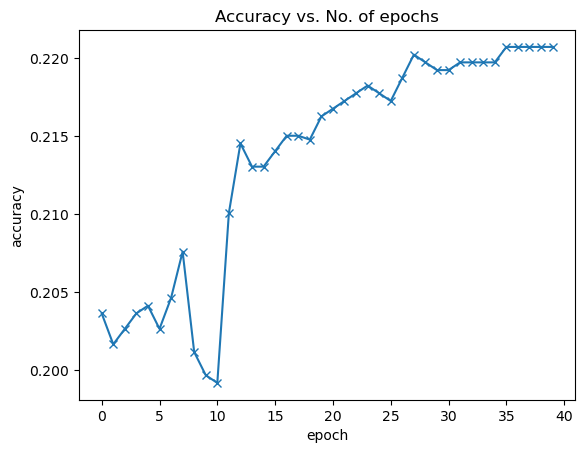

In [24]:
plot_accuracies(history)

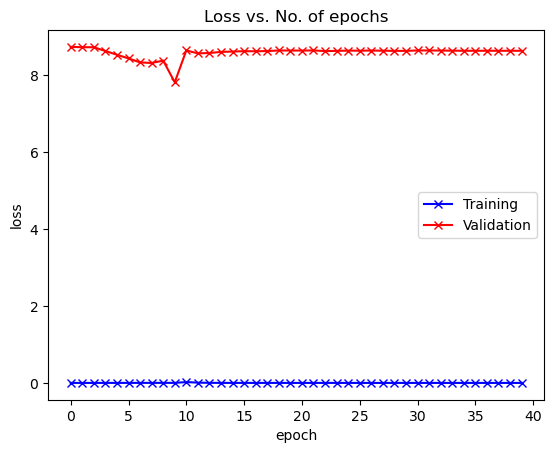

In [25]:
plot_losses(history)

In [18]:
# Reload utils.py after making changes
import importlib
importlib.reload(utils)

<module 'utils' from '/home/diaa/Face_Verification_Siamese_Network/utils.py'>